In [1]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import os
import matplotlib.pyplot as plt

base_dir = "/storage/users/arihant"
base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in os.listdir(base_dir + "/HCP_7T") if len(i) == 6]
base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in os.listdir(base_dir + "/HCP_3T") if len(i) == 6]

path_7t = {}
path_3t = {}


for i in base_dir_7t:
    path_7t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.05.nii.gz" ,"data" : i + "/T1w/Diffusion_7T/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion_7T/bvals" , "bvecs" : i + "/T1w/Diffusion_7T/bvecs"
                      , "brain_mask" : i + "/T1w/Diffusion_7T/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion_7T/grad_dev.nii.gz"}
for i in base_dir_3t:
    path_3t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.25.nii.gz" , "data" : i + "/T1w/Diffusion/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion/bvals" , "bvecs" : i + "/T1w/Diffusion/bvecs"
                       , "brain_mask" : i + "/T1w/Diffusion/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion/grad_dev.nii.gz"}
path = {'3T': path_3t, "7T": path_7t}
p = list(path_7t.keys())
q = list(path_3t.keys())
common = list(set(p) & set(q))


print("number of common Subjects ",len(common))
def load_hcp(id_load,res,ret_img = False):
    load_from = path[res][id_load]
    if ret_img:
        data , affine, img = load_nifti(load_from["data"], return_img=ret_img)
    else:
        data , affine= load_nifti(load_from["data"], return_img=ret_img)
    mask,affine = load_nifti(load_from["brain_mask"], return_img=ret_img)
    scan, affine = load_nifti(load_from["3d_scan"], return_img=False)
    
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    
    return data,mask,scan,gtab

def mean_volume(data,gtab,b):
    if b not in gtab.bvals:
        print("invalid b value")
        return None
    else:
        return np.mean(data , axis = 3 ,where = gtab.bvals == b)

number of common Subjects  171


In [2]:
data,mask,scan,gtab = load_hcp('130114','3T')

In [3]:
data_mean = mean_volume(data,gtab,5)

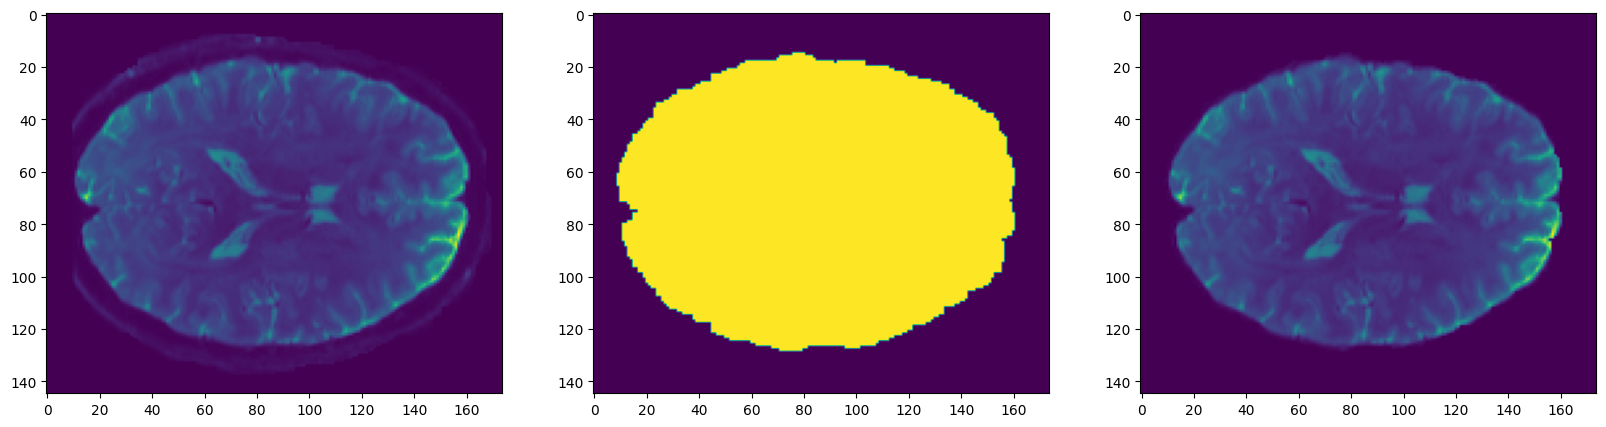

In [4]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].imshow(data_mean[:,:,i])
axis[1].imshow(mask[:,:,i])
axis[2].imshow(mask[:,:,i]*data_mean[:,:,i])

In [5]:
len(gtab.bvals)

288

In [21]:
len(gtab.bvecs[np.where(gtab.bvals > 5)[0]])

270

<IPython.core.display.Javascript object>


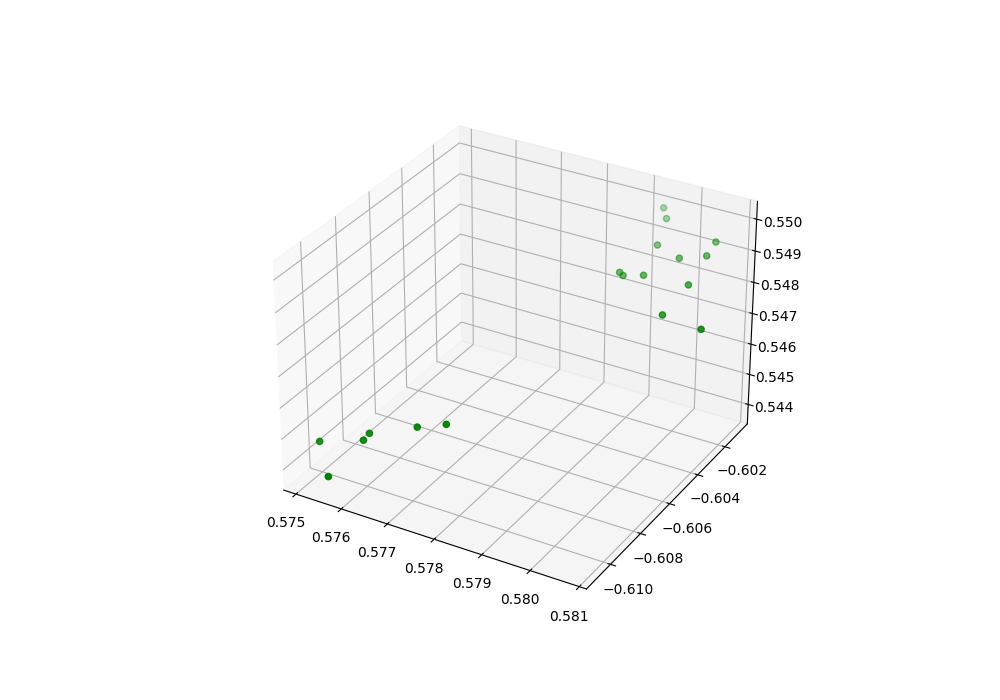

In [7]:
%matplotlib notebook
# import plotly.graph_objects as go
# import numpy as np

x , y, z = gtab.bvecs[np.where(gtab.bvals == 5)[0]][:,0],gtab.bvecs[np.where(gtab.bvals == 5)[0]][:,1],gtab.bvecs[np.where(gtab.bvals == 5)[0]][:,2]

# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
#                                    mode='markers')])
# fig.show()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")

<IPython.core.display.Javascript object>


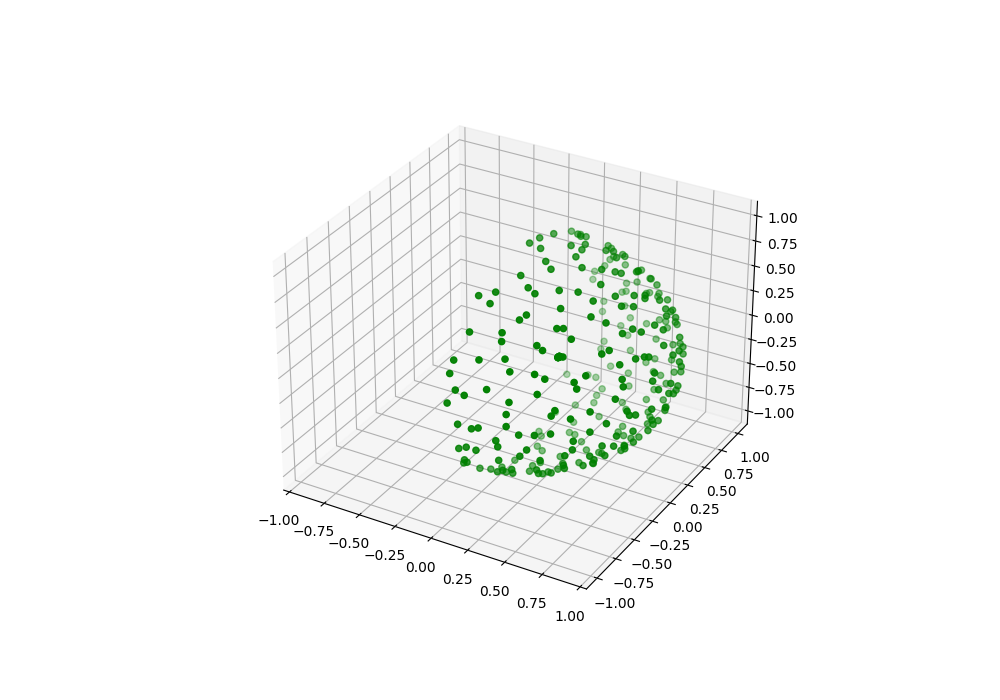

In [8]:

import plotly.graph_objects as go
import numpy as np

x , y, z = gtab.bvecs[:,0],gtab.bvecs[:,1],gtab.bvecs[:,2]

# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
#                                    mode='markers')])
# fig.show()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlim(-1,1)
# Creating plot
ax.scatter3D(x, y, z, color = "green")


In [9]:
data_mean.shape

(145, 174, 145)

## DSM thing

In [147]:
dsm6 = np.array([0.91, 0.416, 0,0, 0.91, 0.416,0.416, 0, 0.91,0.91, -0.416, 0,0, 0.91, -0.416,-0.416, 0, 0.91])

In [148]:
dsm6 = dsm6.reshape(6,3)
dsm_norm = np.copy(dsm6)

In [149]:
dsm6_mag = np.sqrt(dsm6[:,0]**2 + dsm6[:,1]**2 + dsm6[:,2]**2)
for i in range(3):
    dsm_norm[:,i] = dsm6[:,i] / dsm6_mag

In [150]:
dsm_norm

array([[ 0.90947448,  0.41575976,  0.        ],
       [ 0.        ,  0.90947448,  0.41575976],
       [ 0.41575976,  0.        ,  0.90947448],
       [ 0.90947448, -0.41575976,  0.        ],
       [ 0.        ,  0.90947448, -0.41575976],
       [-0.41575976,  0.        ,  0.90947448]])

In [151]:
def rot3d(arg):
    x,y,z = arg[0],arg[1],arg[2]
    Rx = np.array([[1 ,0 ,0 ],[0,np.cos(x),-np.sin(x)],[0 ,np.sin(x) ,np.cos(x)]])
    Ry = np.array([[np.cos(y),0 ,np.sin(y) ],[0,1,0],[-np.sin(y),0,np.cos(y)]])
    Rz = np.array([[np.cos(z) ,-np.sin(z) ,0 ],[np.sin(z),np.cos(z),0],[0 ,0,1]])
    R = Rx @ Ry @ Rz
    return R

def amatrix(mat):
    
    a = [mat[:,0] * mat[:,0],2 * mat[:,0] * mat[:,1], 2* mat[:,0] * mat[:,2],
        mat[:,1] * mat[:,1],2 * mat[:,1] * mat[:,2], mat[:,2] * mat[:,2]]
    return np.array(a).T

    

In [164]:
d= np.random.rand(1,3) * 2 * np.pi
print(d[0])

[2.13407925 4.39434326 1.47573981]


In [165]:
rot3d(d[0])

array([[-0.02968046,  0.31129916, -0.94984836],
       [-0.60777951,  0.74879714,  0.26439915],
       [ 0.79355097,  0.58514586,  0.16697661]])

In [155]:
dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T

In [63]:
dsm_rot.shape

(6, 3)

In [64]:
dsm_rot

array([[-0.69981477, -0.48710564, -0.52248195],
       [ 0.39099736, -0.71070456, -0.58482484],
       [-0.16787264, -0.91866095,  0.3576043 ],
       [-0.96811844, -0.1595081 ,  0.19314205],
       [ 0.19591692, -0.00591506, -0.98060266],
       [ 0.59461111, -0.6230661 ,  0.50815968]])

In [157]:
dirs = gtab.bvecs[np.where(gtab.bvals > 5)[0]]

In [158]:
dirs.shape

(270, 3)

In [159]:
ang_error = abs(dsm_rot @ dirs.T)

In [160]:
ang_error.shape

(6, 270)

In [162]:
# import scipy.io
# mat = scipy.io.loadmat('data.mat')
# mat_bvecs = np.array(mat['bvecs'])
# mat_bval = np.array(mat['bvals'])
# dirs = mat_bvecs[np.where(mat_bval>100)[0]]
# ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
# minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)
# mean_ang_err = np.mean(np.amin(ang_error,1))
# print(amatrix(dirs[idx]))
# np.linalg.cond(amatrix(dirs[idx]))

In [163]:
rotang_all = [];
angerr_all  = [];
condnum_all = [];
ind_all = [];
dirs = np.array(gtab.bvecs[np.where(gtab.bvals > 5)[0]])
for i in range(0,100000):
    
    d = np.random.rand(1,3) * 2 * np.pi
    R = rot3d(d[0])
    dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T
    
    ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
    minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)

    mean_ang_err = np.mean(np.amin(ang_error,1))
    condnum = np.linalg.cond(amatrix(dirs[idx]))

/tmp/ipykernel_2950894/2601381815.py:12: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


% randomly rotate the DSM6 dirs, select their nearest 6 dirs from acquired
% dirs, keep those with low condition number and angel difference.
rotang_all = [];
angerr_all  = [];
condnum_all = [];
ind_all = [];
for ii = 1 : 100000 % number of iterations can be increased in actual implementation
    
    rotangs = rand(1, 3) * 2 * pi; % random angles to rotate around x, y, z axis
    R = rot3d(rotangs); % rotation matrix
    dsm6_rot = (R * dsm6_norm')'; % roated directions
   
    % find 6 nearest dirs in acquired dirs
    angerrors = acosd(abs(dsm6_rot * dirs')); % angles btw rotated DSM6 dirs and acquired dirs
    [minerrors, ind] = min(angerrors, [], 2); % 6 dirs with min angles compared to rotated DSM6 dirs

    meanangerr = mean(minerrors); % mean angle errors of selected dirs
    condnum = cond(amatrix(dirs(ind, :))); % cond number of tensor tx matrix of selected dirs
    
    if meanangerr < 5 && condnum < 1.6 % only use dirs with low angle error and cond number
        if isempty(ind_all) || ~any(sum(ind_all == sort(ind'), 2) == 6) % make sure no repetition
            
            % record params for satisfied sets
            angerr_all = cat(1, angerr_all, meanangerr);
            condnum_all = cat(1, condnum_all, condnum);
            ind_all = cat(1, ind_all, sort(ind'));
            rotang_all = cat(1, rotang_all, rotangs);
        end
    end
end

% here only select 5 sets of directions with lowest condition number
% better to make sure all dwis can be equally slected and used for training 
[~, ind_sort] = sort(condnum_all);
ind_use = ind_all(ind_sort(1 : 5), :);
condnum_use = condnum_all(ind_sort(1 : 5));
angerr_use = angerr_all(ind_sort(1 : 5));
rotang_use = rotang_all(ind_sort(1 : 5), :);

figure; % display two selected sets of 6 optimal directions
for ii = 1 : 2
    subplot(1, 2, ii)
    plot3(dirs_vis(:, 1), dirs_vis(:, 2), dirs_vis(:, 3), '.'); % all dirs
    hold on
    
    visdirs_use = dirs_vis(ind_use(ii, :), :);
    plot3(visdirs_use(:, 1), visdirs_use(:, 2), visdirs_use(:, 3), 'o'); % selected dirs
    
    R = rot3d(rotang_use(ii, :));
    dsm6_rot = (R * dsm6_norm')';
    dsm6_rot_vis = dsm6_rot .* sign(dsm6_rot(:, 3));
    plot3(dsm6_rot_vis(:, 1), dsm6_rot_vis(:, 2), dsm6_rot_vis(:, 3), 'x'); % rotated DSM6 dirs
    
    grid on, axis equal
    xlim([-1, 1])
    ylim([-1, 1])
    zlim([-1, 1])
    title(['cond num=' num2str(condnum_use(ii))]);
end